In [2]:
import pandas as pd
import sys
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
datadir = "/media/sf_VBox_Shared/London/accelerometer_5second/merged/"
path_to_file5sec = os.path.join(datadir, "__016563_2014-08-08 12-02-19.bin_day1.csv")

In [4]:
filenames = os.listdir(datadir)
datasets = [pd.read_csv(os.path.join(datadir,fn)) for fn in filenames if os.path.isfile(os.path.join(datadir,fn))]
print(len(datasets))

21


In [5]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 
    datasets[i]['Activity'] = [str(a) for a in datasets[i]['Activity']]

In [6]:
subsets = []
for j, dataset in enumerate(datasets):
    invalids = [1] + list(dataset['invalid']) + [1]
    starts = [i for i in range(1, len(invalids)-1) if invalids[i-1] == 1 and invalids[i] == 0]
    ends = [i for i in range(1, len(invalids)) if invalids[i-1] == 0 and invalids[i] == 1]
    dataset['subset'] = -1
    for i, (s, e) in enumerate(zip(starts, ends)):
        #Some minimum length
        if e-s > 300:
            dataset.loc[s:e, 'subset'] = i
            subsets.append(dataset[s:e].copy())
print(len(subsets))
datasets = subsets

23


In [38]:
#TODO: something with edges of valid periods?
for i in range(len(datasets)):
    print(sum(datasets[i]['invalid'] == 1), datasets[i].shape)

(0, (17279, 7))
(0, (17278, 7))
(1, (16560, 7))
(0, (17279, 7))
(1, (6480, 7))
(0, (17279, 7))
(0, (17279, 7))
(1, (900, 7))
(0, (14398, 7))
(0, (17279, 7))
(0, (17278, 7))
(0, (17279, 7))
(1, (540, 7))
(0, (12598, 7))
(1, (13320, 7))
(1, (12780, 7))
(1, (12600, 7))
(0, (17279, 7))
(0, (17278, 7))
(0, (17279, 7))
(0, (17278, 7))
(1, (11880, 7))
(1, (13500, 7))


In [35]:
all_data = pd.concat(datasets)

## Explore distributions

In [36]:
all_acceleration = all_data['acceleration']
print all_acceleration.shape

(322900,)


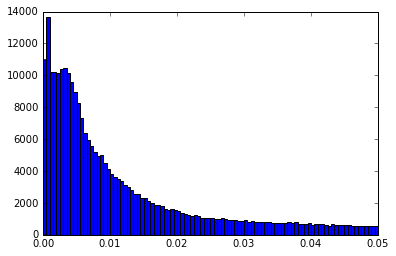

In [9]:
plt.hist(all_acceleration[all_acceleration<0.05], bins=100)
plt.xlim(0, 0.05)
plt.show()

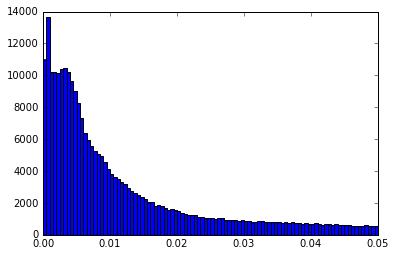

In [10]:
log_acceleration =  np.log(all_acceleration+1)
plt.hist(log_acceleration[log_acceleration<0.05], bins=100)
#plt.xlim(0, 0.05)
#plt.ylim(0,2000)
plt.show()

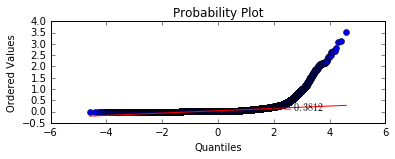

In [11]:
from scipy import stats
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(all_acceleration, dist=stats.norm, plot=ax1)
plt.show()

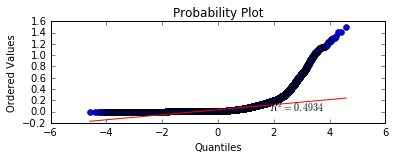

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(log_acceleration, dist=stats.norm, plot=ax1)
plt.show()

In [13]:
vals = np.sqrt(all_acceleration)
df, loc, scale = stats.chi2.fit(vals)
print(df, loc, scale)

(1.8691528604679908, -6.2982215056047213e-29, 0.081528304175292415)


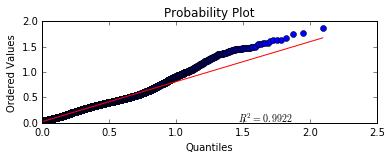

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(vals, dist=stats.chi2, sparams=(df, loc, scale), plot=ax1)
plt.show()

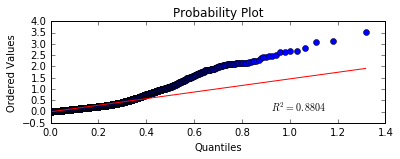

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
shape, loc, scale = stats.weibull_min.fit(all_acceleration)
stats.probplot(all_acceleration, dist=stats.weibull_min, sparams=(shape, loc, scale), plot=ax1)
plt.show()

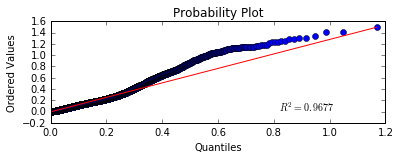

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
shape, loc, scale = stats.weibull_min.fit(log_acceleration)
stats.probplot(log_acceleration, dist=stats.weibull_min, sparams=(shape, loc, scale), plot=ax1)
plt.show()

## Box-Cox

In [17]:
bc_acceleration, bc_lmbda = stats.boxcox(all_acceleration+1)

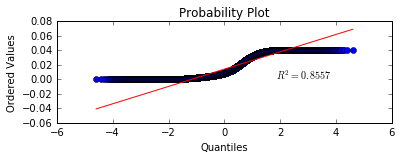

In [18]:
fig = plt.figure()
ax2 = fig.add_subplot(211)
stats.probplot(bc_acceleration, dist=stats.norm, plot=ax2)
plt.show()

In [19]:
bc_lmbda

-24.32849896078471

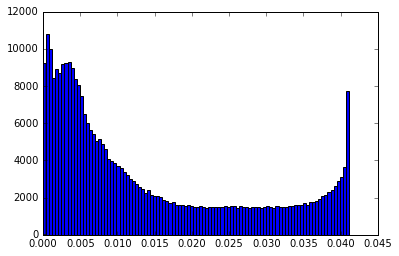

In [20]:
log_acceleration =  np.log(all_acceleration+1)
plt.hist(bc_acceleration, bins=100)
plt.show()

## Angles

(-24.9636692266577, 3.6391810908308302)
(-27.600527203902598, 12.751702513908999)
(-28.598281546256047, -6.7938511329970748)
(-31.079258611053199, 7.85733969477005)
(-3.1927149539766804, 4.7337672965228546)
(-21.771005889102806, -2.96105148231611)
(26.369941228227702, -5.5206756716221603)
(28.356732980657547, -2.7839073917851751)
(-1.0245597411738752, 0.48770636561472203)
(32.119765047933896, 3.95289950706414)
(-32.83280864320465, -1.36795208452968)
(-24.557009074054694, -4.0632903981953898)
(0.53814767053379897, -82.026002741599541)
(-34.942469452451945, -0.67742601197212937)
(28.627582955351102, -0.474967908898834)
(40.7123204495199, -23.920825255159251)
(-25.261922359984599, -23.273250424377601)
(-39.772328649651001, 10.7347174700908)
(-33.287065690532351, 16.447566648051151)
(-27.916581037417107, -7.5389512702287185)
(-40.506064110025747, -11.1109154437017)
(-31.568280722359198, 28.192703570714251)
(-29.975110217239703, 5.8335745730157935)


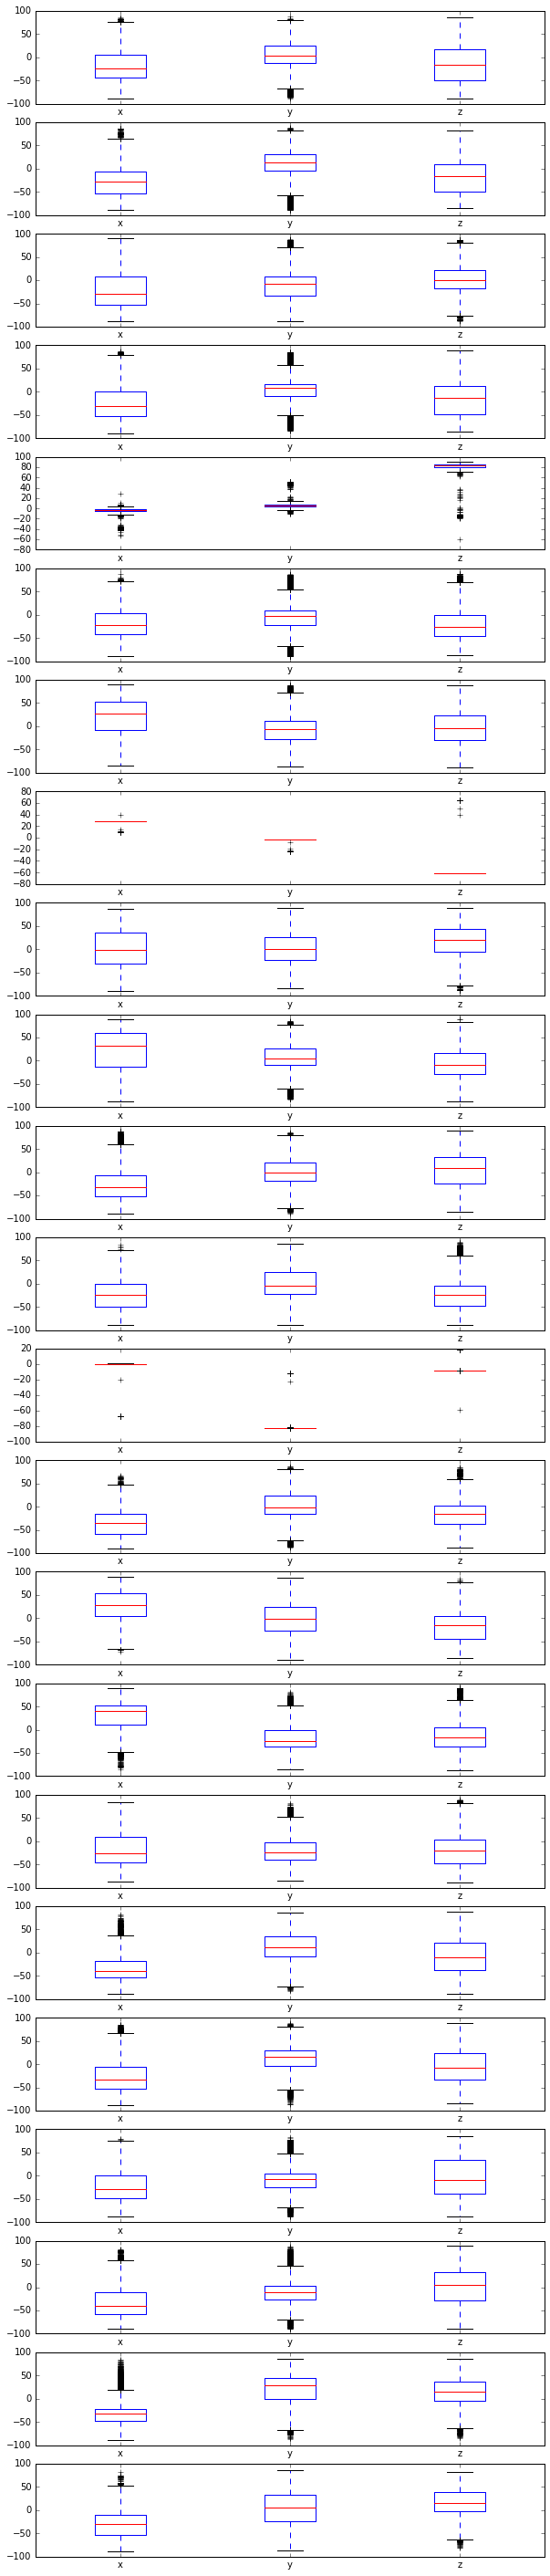

In [56]:
#Create boxplots for each sequence for the angles
#We expect x (and thus anglex) to be distributed either mostly on the negative or mostly on the positive half
fig, axes = plt.subplots(len(datasets), figsize=(10, 50))
for i, dataset in enumerate(datasets):
    print(np.median(dataset['anglex']), np.median(dataset['angley']))
    axes[i].boxplot([dataset['anglex'], dataset['angley'], dataset['anglez']], labels=['x', 'y', 'z']);

In [54]:
# Switch the sign of angle x and y if the orientation seems to be switcht
dataset_switched = [dataset.copy() for dataset in datasets]
for dataset in dataset_switched:
    non_sleeping_indices = dataset['Activity'] != 'Sleepingandresting(includingsickinbed)'
    non_sleeping = dataset[non_sleeping_indices]
    if not non_sleeping.empty:
        # in the 'correct' orientation, anglex should be mostly negative
        med_x = np.median(non_sleeping['anglex'])
        print(med_x)
        if med_x > 0:
            dataset['anglex'] *= -1
            dataset['angley'] *= -1
    else:
        print('sleeping: ', np.median(dataset['anglex']))

-29.4262960475
-35.3814196105
-26.4394076892
-35.0465356999
-3.19271495398
-21.3587488435
29.6713498471
('sleeping: ', 28.356732980657547)
-1.02455974117
40.8851134739
-32.9689830756
-28.802153774
('sleeping: ', 0.53814767053379897)
-34.9424694525
39.4320910254
38.74938112
-25.26192236
-40.6162910972
-37.7248650457
-37.9352915473
-40.50606411
-34.6644670067
-36.0015680954


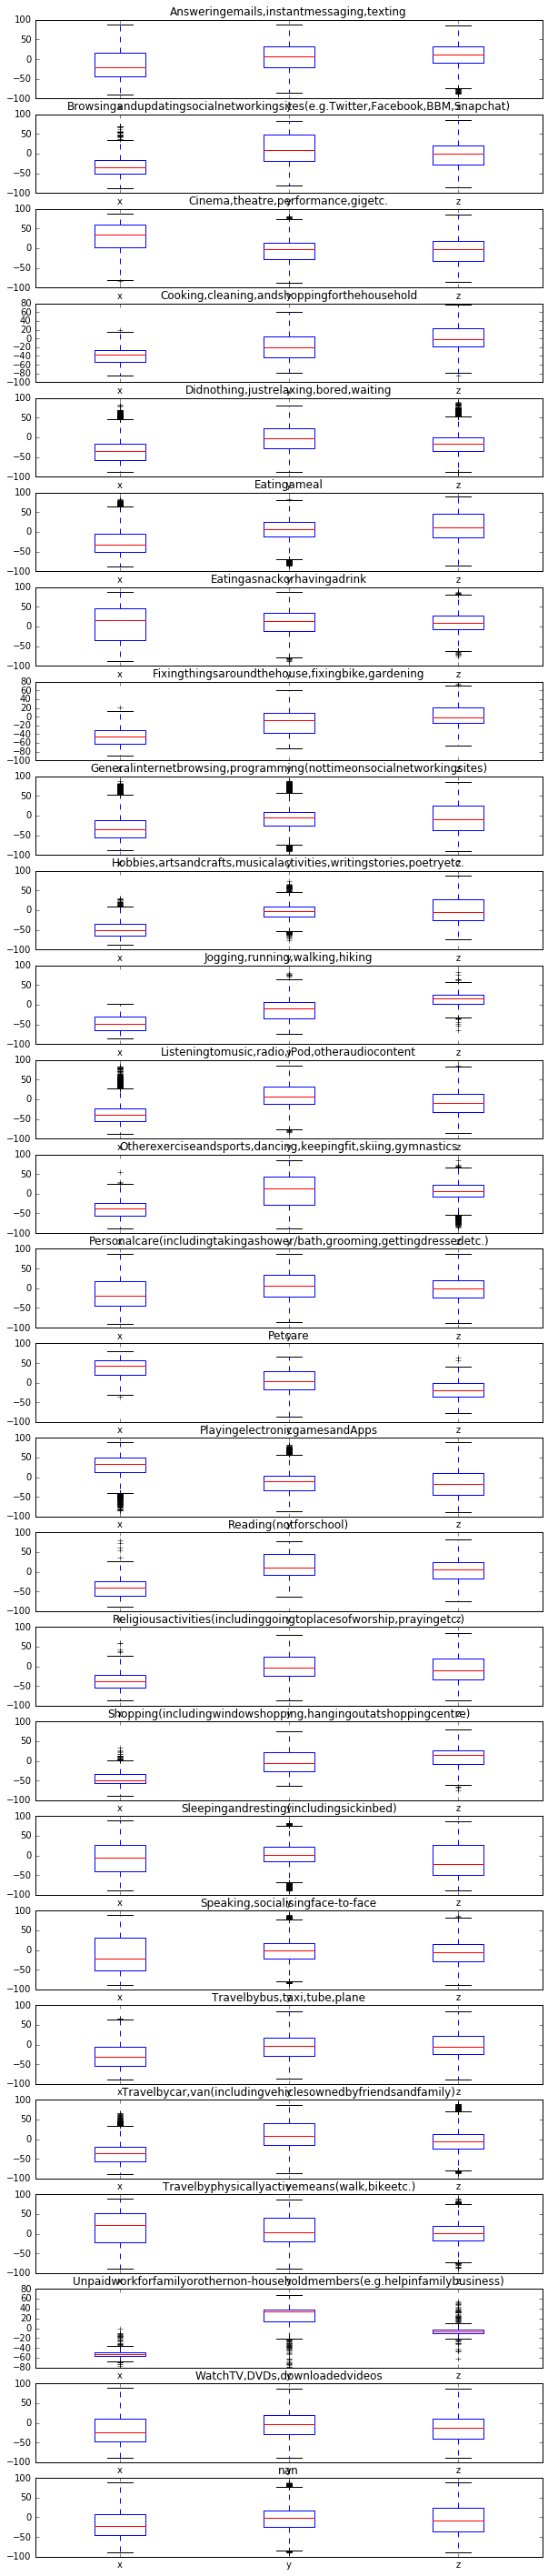

In [55]:
# Look at the distrubtions per activity
by_act = all_data.groupby('Activity')
fig, axes = plt.subplots(len(by_act), figsize=(10, 50))
for i, (activity, dataset) in enumerate(by_act):
    axes[i].boxplot([dataset['anglex'], dataset['angley'], dataset['anglez']], labels=['x', 'y', 'z'])
    axes[i].set_title(activity)

In [21]:
anglex = np.array([s for d in datasets for s in list(np.array(d['anglex']))])
angley = np.array([s for d in datasets for s in list(np.array(d['angley']))])
anglez = np.array([s for d in datasets for s in list(np.array(d['anglez']))])

In [22]:
total = anglex + angley + anglez

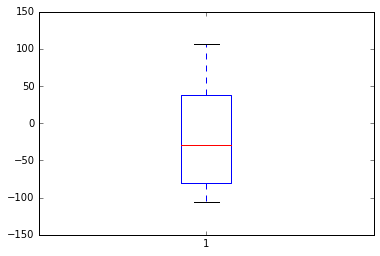

In [23]:
plt.boxplot(total);

In [24]:
print(min(total), max(total))

(-105.79232705637111, 105.7917641012513)


In [25]:
print min(anglex), max(anglex)
print min(angley), max(angley)
print min(anglez), max(anglez)

-89.6604685817 89.6494739844
-89.4480531425 88.7492992507
-89.5119938246 89.7698463821


In [26]:
radtodegree = 180/np.pi
theta = anglex/radtodegree
psi = angley/radtodegree
phi = anglez/radtodegree

In [27]:
x = np.sin(theta)
y = np.sin(psi)
z = np.tan(phi)*np.sqrt(x**2 + y**2)

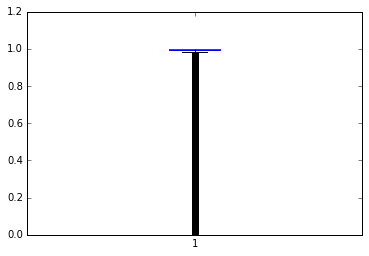

In [28]:
acc = x**2 + y**2 + z**2
plt.boxplot(acc);

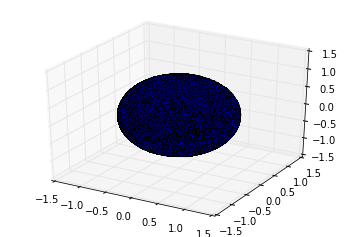

In [29]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='black', s=5)

In [30]:
print min(anglex + angley), max(anglex + angley)

-89.999998787 89.9999836928


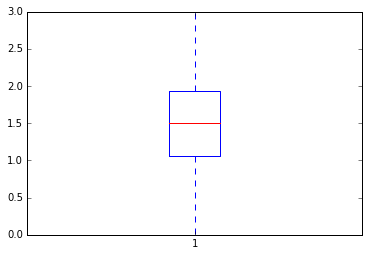

In [31]:
radtodegree = np.pi/180
radius = np.sin(anglex/radtodegree)**2 + np.sin(angley/radtodegree)**2 + np.sin(anglez/radtodegree)**2
plt.boxplot(radius);

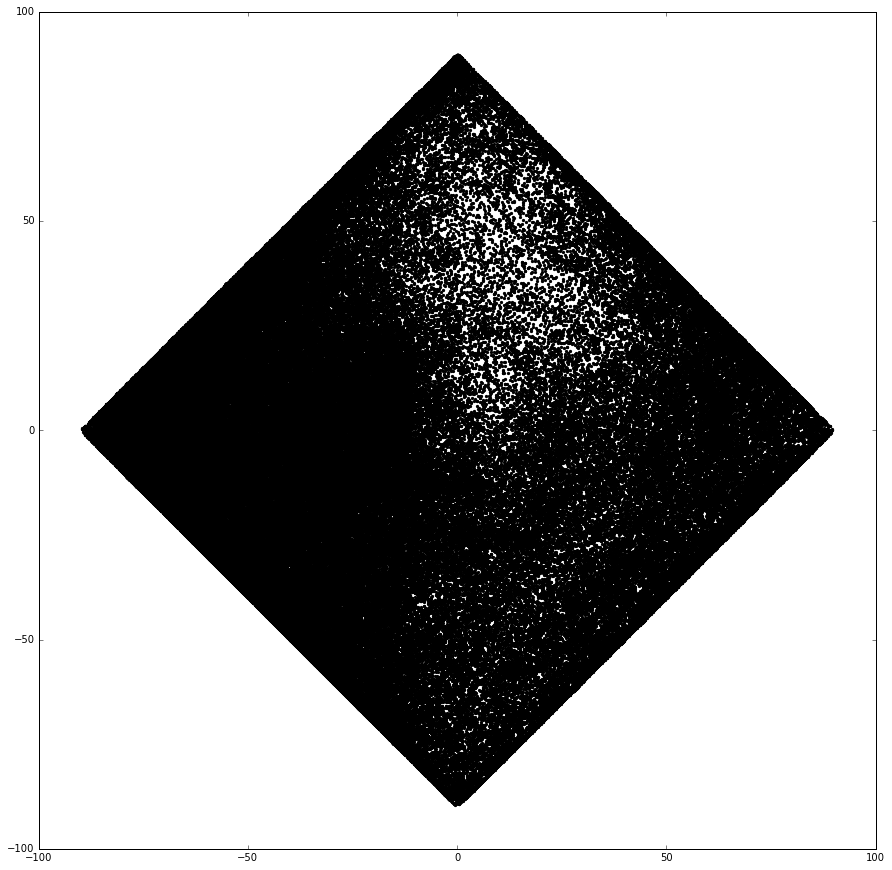

In [32]:
fig = subplots(figsize=(15, 15))
plt.scatter(anglex, anglez, color='black', s=5);